In [1]:
import os
import sys
from pathlib import Path

module_path = os.path.abspath(os.path.join('../vlad'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from numpy.linalg import norm
import cv2
import matplotlib.pyplot as plt
import progressbar as pb

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from vlad import VLAD

In [5]:
query_path = Path('/home/tim/Hahn-Schickard/Bachelorarbeit/Datensätze/Eisengussteile/Typ668/00_Durchgang1')
db_path = Path('/home/tim/Hahn-Schickard/Bachelorarbeit/Datensätze/Eisengussteile/Typ668/01_Durchgang2')

query_files = sorted([x for x in query_path.iterdir() if x.is_file()], key=lambda x: int(x.name.split('_')[-1].split('.')[0]))
db_files = sorted([x for x in db_path.iterdir() if x.is_file()], key=lambda x: int(x.name.split('_')[-1].split('.')[0]))

## Testing with ORB-descriptors

In [6]:
_nfeatures = 1000
orb = cv2.ORB_create(_nfeatures, nlevels=4, scaleFactor=1.5)

In [46]:
DB_TENSOR_ORB = Path("db-tensor-orb.npy")

if not DB_TENSOR_ORB.exists():
    descs_lst = []
    for file in pb.progressbar(db_files):
        img = cv2.imread(str(file), 0)
        img = cv2.equalizeHist(img)
        _, descs = orb.detectAndCompute(img, None)
        descs_lst.append(descs[:_nfeatures])

    db_tensor = np.dstack(descs_lst)
    np.save(DB_TENSOR_ORB, db_tensor)
else:
    db_tensor = np.load(DB_TENSOR_ORB)

In [47]:
QUERY_TENSOR_ORB = Path("query-tensor-orb.npy")

if not QUERY_TENSOR_ORB.exists():
    descs_lst = []
    for file in pb.progressbar(query_files):
        img = cv2.imread(str(file), 0)
        img = cv2.equalizeHist(img)
        _, descs = orb.detectAndCompute(img, None)
        descs_lst.append(descs)

    query_tensor = np.dstack(descs_lst)
    np.save(QUERY_TENSOR_ORB, query_tensor)
else:
    query_tensor = np.load(QUERY_TENSOR_ORB)

In [9]:
VOCAB_FILE = Path("dictionary-orb.npy")
vlad_orb = VLAD()

if VOCAB_FILE.exists():
    vlad_orb.load_vocab(VOCAB_FILE)

vlad_orb.fit(db_tensor)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:11 Time:  0:00:11


In [10]:
vlad.database.shape

(1000, 8192)

In [11]:
scores = np.zeros((query_tensor.shape[-1], vlad.database.shape[0]))

for i in pb.progressbar(range(len(scores))):
    scores[i] = vlad.predict_proba(query_tensor[...,i])

100% (999 of 999) |######################| Elapsed Time: 0:00:20 Time:  0:00:20


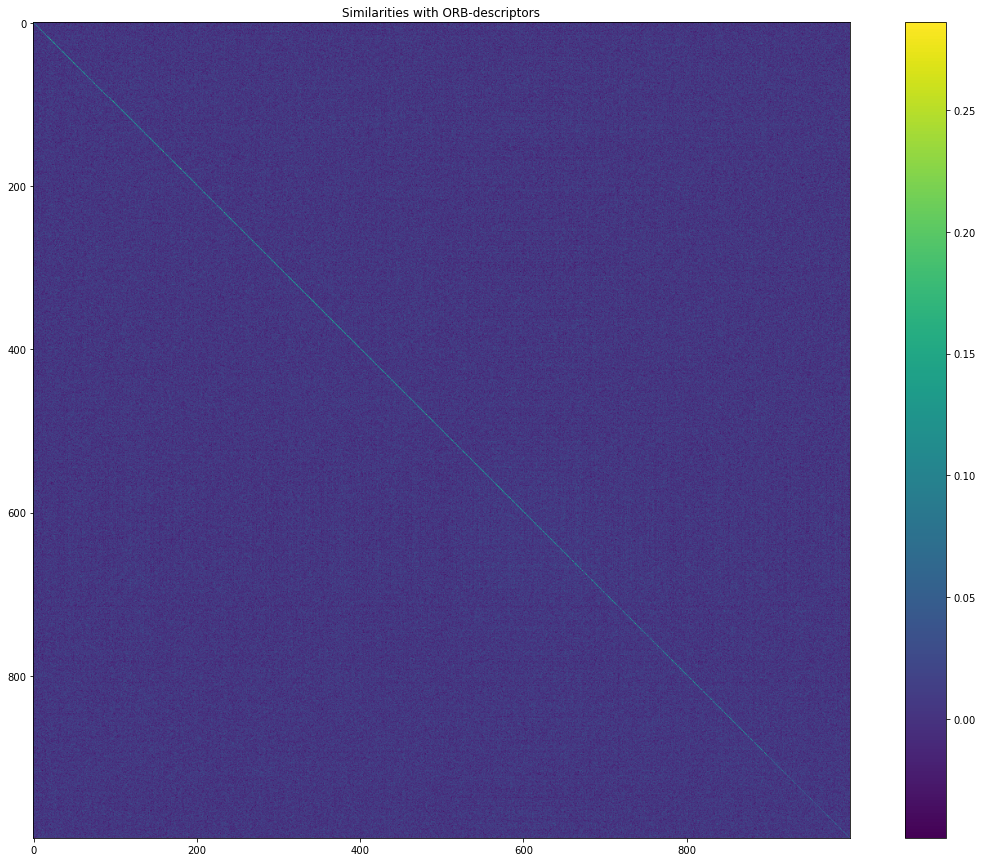

In [18]:
plt.figure(figsize=(20,15))
plt.imshow(scores)
plt.title("Similarities with ORB-descriptors")
plt.colorbar();

In [44]:
(np.argmax(scores, axis=1) != np.delete(np.arange(1000), 92)).sum()  # Count number of false classifications

36

One can see, that towards the end of the dataset the confidence goes down quite a bit. Let's see, if this is any different with RootSIFT-descriptors. Note, that i didn't search for good parameters for RootSIFT!

## RootSIFT

In [45]:
sift = cv2.SIFT_create(_nfeatures)

In [48]:
DB_TENSOR_SIFT = Path("db-tensor-sift.npy")

if not DB_TENSOR_SIFT.exists():
    descs_lst = []
    for file in pb.progressbar(db_files):
        img = cv2.imread(str(file), 0)
        img = cv2.equalizeHist(img)
        _, descs = sift.detectAndCompute(img, None)
        descs_lst.append(descs[:_nfeatures])

    db_tensor = np.dstack(descs_lst)
    np.save(DB_TENSOR_SIFT, db_tensor)
else:
    db_tensor = np.load(DB_TENSOR_SIFT)

100% (1000 of 1000) |####################| Elapsed Time: 0:15:18 Time:  0:15:18


In [50]:
QUERY_TENSOR_SIFT = Path("query-tensor-sift.npy")

if not QUERY_TENSOR_SIFT.exists():
    descs_lst = []
    for file in pb.progressbar(query_files):
        img = cv2.imread(str(file), 0)
        img = cv2.equalizeHist(img)
        _, descs = sift.detectAndCompute(img, None)
        descs_lst.append(descs[:_nfeatures])

    query_tensor = np.dstack(descs_lst)
    np.save(QUERY_TENSOR_SIFT, query_tensor)
else:
    query_tensor = np.load(QUERY_TENSOR_SIFT)

100% (999 of 999) |######################| Elapsed Time: 0:14:00 Time:  0:14:00


In [62]:
def RootSIFT(descs):
    if isinstance(descs, list):
        for i in range(len(descs)):
            descs[i] = np.sqrt(descs[i] / norm(descs, ord=1, axis=1))
    elif isinstance(descs, np.ndarray):
        descs = np.sqrt(descs / norm(descs, ord=1, axis=1)[:,np.newaxis])  # New axis in order to broadcast correctly
    else:
        print("{} not supported! Choose one of [list, numpy.ndarray].".format(type(descs)))
        return
    return descs

In [63]:
db_tensor = RootSIFT(db_tensor)  # SIFT -> RootSIFT
query_tensor = RootSIFT(query_tensor)

In [64]:
vlad_rs = VLAD().fit(db_tensor)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:26 Time:  0:00:26


In [65]:
scores = np.zeros((query_tensor.shape[-1], vlad_rs.database.shape[0]))

for i in pb.progressbar(range(len(scores))):
    scores[i] = vlad_rs.predict_proba(query_tensor[...,i])

100% (999 of 999) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


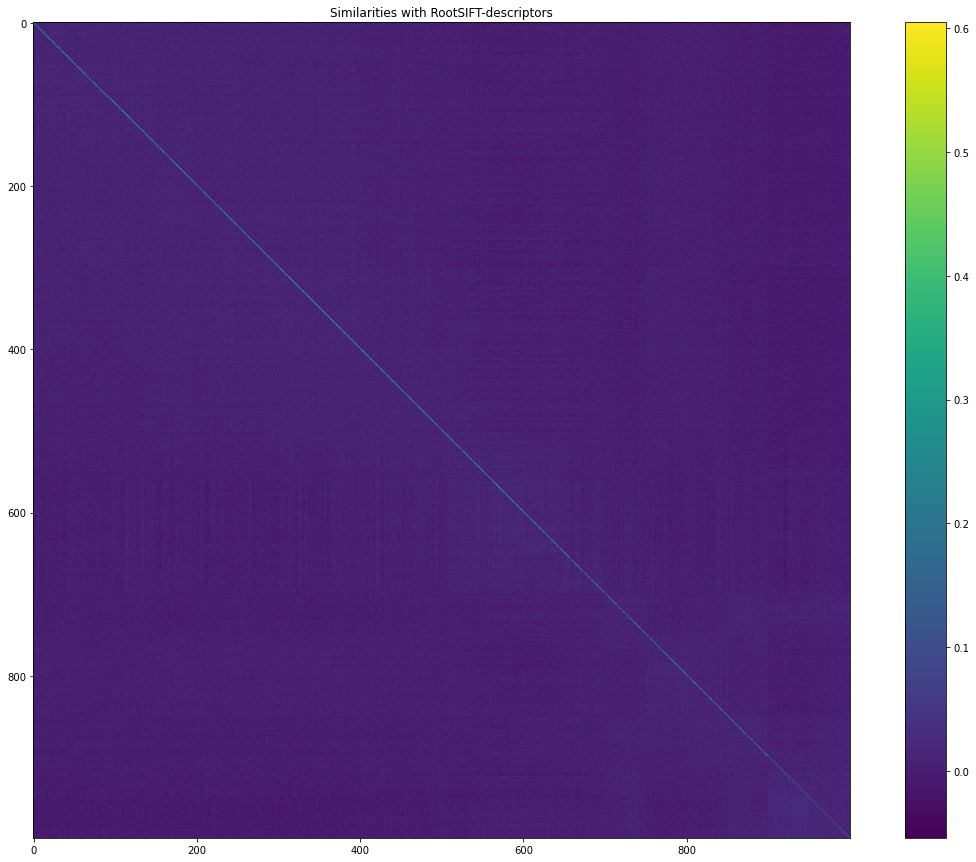

In [66]:
plt.figure(figsize=(20,15))
plt.imshow(scores)
plt.title("Similarities with RootSIFT-descriptors")
plt.colorbar();

In [67]:
(np.argmax(scores, axis=1) != np.delete(np.arange(1000), 92)).sum()  # Count number of false classifications

3